In [2]:
# NumPy, Pandas, PIL, scikit-learn y Matplotlib
%pip install numpy pandas pillow scikit-learn matplotlib

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.9 kB 330.3 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.9 kB 325.1 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.9 kB 326.8 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.9 kB 326.8 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.9 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 202.8 kB/s eta 0:00:00
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.2 MB/s eta 0:00:00
  Using cached 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA compilada en Torch:", torch.version.cuda)
print("CUDA disponible?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Dispositivo:", torch.cuda.get_device_name(0))
    print("Número de GPUs:", torch.cuda.device_count())


Torch version: 2.7.1+cu128
CUDA compilada en Torch: 12.8
CUDA disponible?: True
Dispositivo: NVIDIA GeForce RTX 5050 Laptop GPU
Número de GPUs: 1


In [2]:
%pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.


In [3]:
%pip install torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 465.5 kB/s eta 1:57:12
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 653.6 kB/s eta 1:23:28
   ---------------------------------------- 0.0/3.3 GB 1.0 MB/s eta 0:53:54
   ---------------------------------------- 0.0/3.3 GB 983.0 kB/s eta 0:55:30
   --------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from sklearn.metrics import f1_score

In [28]:
# =========================
# Bloque E1: Imports y config
# =========================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

import matplotlib.pyplot as plt

# ---- Ruta a la carpeta de imágenes ORIGINALES ----
# AJUSTA ESTA RUTA A TU PC
ROOT_DIR = Path(r"C:\Users\Kevin\OneDrive\Desktop\trabajo_final_deep\Fruits Original")
assert ROOT_DIR.exists(), f"No se encontró la ruta: {ROOT_DIR}"

# ---- Dispositivo ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)

# ---- Semilla para reproducibilidad ----
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Usando dispositivo: cuda


In [29]:
# ============================================
# Bloque E2: Construir tabla de imágenes + split
# ============================================

def build_index(root: Path):
    registros = []
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP"}
    
    for fruit_dir in sorted(root.iterdir()):
        if not fruit_dir.is_dir():
            continue
        fruit = fruit_dir.name  # Apple, Banana, ...

        for status_dir in sorted(fruit_dir.iterdir()):
            if not status_dir.is_dir():
                continue
            status = status_dir.name  # Fresh, Rotten, Formalin-mixed, ...
            class_name = f"{fruit}_{status}"

            for img_path in status_dir.iterdir():
                if img_path.suffix in exts:
                    registros.append({
                        "path": str(img_path),
                        "fruit": fruit,
                        "status": status,
                        "class_name": class_name,
                    })
    return pd.DataFrame(registros)

df = build_index(ROOT_DIR)
print("Total de imágenes:", len(df))
df.head()


Total de imágenes: 10154


,path,fruit,status,class_name
0,C:\Users\Kevin\OneDrive\Desktop\trabajo_final_...,Apple,Formalin-mixed,Apple_Formalin-mixed
1,C:\Users\Kevin\OneDrive\Desktop\trabajo_final_...,Apple,Formalin-mixed,Apple_Formalin-mixed
2,C:\Users\Kevin\OneDrive\Desktop\trabajo_final_...,Apple,Formalin-mixed,Apple_Formalin-mixed
3,C:\Users\Kevin\OneDrive\Desktop\trabajo_final_...,Apple,Formalin-mixed,Apple_Formalin-mixed
4,C:\Users\Kevin\OneDrive\Desktop\trabajo_final_...,Apple,Formalin-mixed,Apple_Formalin-mixed


In [30]:
# Distribución por clase
df["class_name"].value_counts()


class_name
Grape_Fresh              770
Apple_Fresh              765
Mango_Fresh              763
Orange_Fresh             753
Banana_Fresh             749
Banana_Formalin-mixed    660
Orange_Rotten            656
Orange_Formalin-mixed    647
Apple_Formalin-mixed     643
Banana_Rotten            632
Apple_Rotten             630
Mango_Rotten             630
Grape_Rotten             630
Mango_Formalin-mixed     616
Grape_Formalin-mixed     610
Name: count, dtype: int64

In [31]:
# Mapear class_name -> índice
class_names = sorted(df["class_name"].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for name, i in class_to_idx.items()}

df["label"] = df["class_name"].map(class_to_idx)

num_classes = len(class_names)
print("Número de clases:", num_classes)
print("Clases:", class_names)


Número de clases: 15
Clases: ['Apple_Formalin-mixed', 'Apple_Fresh', 'Apple_Rotten', 'Banana_Formalin-mixed', 'Banana_Fresh', 'Banana_Rotten', 'Grape_Formalin-mixed', 'Grape_Fresh', 'Grape_Rotten', 'Mango_Formalin-mixed', 'Mango_Fresh', 'Mango_Rotten', 'Orange_Formalin-mixed', 'Orange_Fresh', 'Orange_Rotten']


In [32]:
# Split estratificado 70/15/15
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42,
)

len(train_df), len(val_df), len(test_df)


(7107, 1523, 1524)

In [33]:
# Comprobar distribución de clases en cada split (opcional)
print("Train:")
print(train_df["class_name"].value_counts(normalize=True).round(3))

print("\nVal:")
print(val_df["class_name"].value_counts(normalize=True).round(3))

print("\nTest:")
print(test_df["class_name"].value_counts(normalize=True).round(3))


Train:
class_name
Grape_Fresh              0.076
Apple_Fresh              0.075
Mango_Fresh              0.075
Orange_Fresh             0.074
Banana_Fresh             0.074
Banana_Formalin-mixed    0.065
Orange_Rotten            0.065
Orange_Formalin-mixed    0.064
Apple_Formalin-mixed     0.063
Banana_Rotten            0.062
Apple_Rotten             0.062
Grape_Rotten             0.062
Mango_Rotten             0.062
Mango_Formalin-mixed     0.061
Grape_Formalin-mixed     0.060
Name: proportion, dtype: float64

Val:
class_name
Grape_Fresh              0.076
Apple_Fresh              0.075
Mango_Fresh              0.075
Orange_Fresh             0.074
Banana_Fresh             0.074
Banana_Formalin-mixed    0.065
Orange_Rotten            0.064
Orange_Formalin-mixed    0.064
Apple_Formalin-mixed     0.063
Mango_Rotten             0.062
Banana_Rotten            0.062
Grape_Rotten             0.062
Apple_Rotten             0.062
Mango_Formalin-mixed     0.061
Grape_Formalin-mixed     0.060
Na

In [34]:
# ===========================================
# Bloque E3: Calcular mean/std y definir transforms
# ===========================================

def compute_mean_std(df_subset, sample_size=1000):
    paths = df_subset["path"].tolist()
    if sample_size is not None and sample_size < len(paths):
        paths = random.sample(paths, sample_size)
    
    means, stds = [], []
    basic_transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = basic_transform(img)
        means.append(x.mean(dim=(1, 2)))
        stds.append(x.std(dim=(1, 2)))
    
    mean = torch.stack(means).mean(dim=0)
    std = torch.stack(stds).mean(dim=0)
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(train_df, sample_size=1000)
print("Mean:", mean)
print("Std:", std)


Mean: [0.6631208062171936, 0.6321953535079956, 0.5735348463058472]
Std: [0.12329615652561188, 0.13154181838035583, 0.21672791242599487]


In [35]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

val_test_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])


In [36]:
# ==============================
# Bloque E4: Dataset + DataLoader
# ==============================

class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["label"])
        
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

BATCH_SIZE = 32
NUM_WORKERS = 0  # en Windows + Jupyter mejor 0

train_dataset = FruitDataset(train_df, transform=train_transform)
val_dataset   = FruitDataset(val_df,   transform=val_test_transform)
test_dataset  = FruitDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_dataset), len(val_dataset), len(test_dataset)


(7107, 1523, 1524)

In [37]:
# ==============================
# Bloque E4: Dataset + DataLoader
# ==============================

class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["label"])
        
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

BATCH_SIZE = 32
NUM_WORKERS = 0  # en Windows + Jupyter mejor 0

train_dataset = FruitDataset(train_df, transform=train_transform)
val_dataset   = FruitDataset(val_df,   transform=val_test_transform)
test_dataset  = FruitDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_dataset), len(val_dataset), len(test_dataset)


(7107, 1523, 1524)

In [38]:
# ======================================================
# Bloque E5: Funciones train_one_epoch y evaluate (clasif)
# ======================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits = model(xb)
            loss = criterion(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [39]:
# ==========================================
# Bloque E3: Red de embeddings (siamesa)
# ==========================================

class EmbeddingNet(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 256 -> 128

            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 128 -> 64

            # Bloque 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 64 -> 32

            # Bloque 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 32 -> 16
        )
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc   = nn.Linear(256, embed_dim)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # normalizamos el embedding para que la distancia L2/coseno sea más estable
        x = F.normalize(x, p=2, dim=1)
        return x

embedding_net = EmbeddingNet(embed_dim=EMBED_DIM).to(DEVICE)
print(embedding_net)


EmbeddingNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [40]:
# ==========================================
# Bloque E6: Dataset para Triplet Loss
# ==========================================

class TripletDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
        self.label_to_indices = {}
        for lbl in sorted(self.df["label"].unique()):
            self.label_to_indices[lbl] = self.df.index[self.df["label"] == lbl].tolist()
        
        self.labels = self.df["label"].tolist()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        anchor_row = self.df.iloc[idx]
        anchor_path = anchor_row["path"]
        anchor_label = int(anchor_row["label"])
        
        # positive
        pos_idx = idx
        pos_candidates = self.label_to_indices[anchor_label]
        if len(pos_candidates) > 1:
            while pos_idx == idx:
                pos_idx = random.choice(pos_candidates)
        pos_row = self.df.iloc[pos_idx]
        pos_path = pos_row["path"]
        
        # negative
        neg_label = anchor_label
        while neg_label == anchor_label:
            neg_label = random.choice(list(self.label_to_indices.keys()))
        neg_idx = random.choice(self.label_to_indices[neg_label])
        neg_row = self.df.iloc[neg_idx]
        neg_path = neg_row["path"]
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        pos_img    = Image.open(pos_path).convert("RGB")
        neg_img    = Image.open(neg_path).convert("RGB")
        
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            pos_img    = self.transform(pos_img)
            neg_img    = self.transform(neg_img)
        
        return anchor_img, pos_img, neg_img, anchor_label

TRIPLET_BATCH_SIZE = 32

triplet_train_dataset = TripletDataset(train_df, transform=train_transform)
triplet_val_dataset   = TripletDataset(val_df,   transform=val_test_transform)

triplet_train_loader = DataLoader(
    triplet_train_dataset,
    batch_size=TRIPLET_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
triplet_val_loader = DataLoader(
    triplet_val_dataset,
    batch_size=TRIPLET_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

len(triplet_train_dataset), len(triplet_val_dataset)


(7107, 1523)

In [41]:
# ==========================================
# Bloque E7: Backbone mini-ResNet para embeddings
# ==========================================

EMBED_DIM = 128  # tamaño del vector de características

class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.skip = None
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out, inplace=True)
        return out


class EmbeddingNetV2(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )  # 256 -> 128

        self.layer1 = BasicBlock(64, 64, stride=1)    # 128x128
        self.layer2 = BasicBlock(64, 128, stride=2)   # 64x64
        self.layer3 = BasicBlock(128, 256, stride=2)  # 32x32
        self.layer4 = BasicBlock(256, 512, stride=2)  # 16x16

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc   = nn.Sequential(
            nn.Linear(512, embed_dim, bias=False),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

embedding_net = EmbeddingNetV2(embed_dim=EMBED_DIM).to(DEVICE)
print(embedding_net)


EmbeddingNetV2(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [42]:
# ==============================================
# Bloque E8: Entrenamiento siamesa (triplet loss)
# ==============================================

TRIPLET_MARGIN = 1.0
TRIPLET_EPOCHS = 20
LR_TRIPLET = 1e-3

triplet_criterion = nn.TripletMarginLoss(margin=TRIPLET_MARGIN, p=2)
triplet_optimizer = torch.optim.Adam(embedding_net.parameters(), lr=LR_TRIPLET)

def train_triplet_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total = 0
    
    for anchor, positive, negative, _ in loader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()
        emb_a = model(anchor)
        emb_p = model(positive)
        emb_n = model(negative)
        
        loss = criterion(emb_a, emb_p, emb_n)
        loss.backward()
        optimizer.step()
        
        batch_size = anchor.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size
    
    epoch_loss = running_loss / total
    return epoch_loss

def eval_triplet(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    
    with torch.no_grad():
        for anchor, positive, negative, _ in loader:
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)
            
            loss = criterion(emb_a, emb_p, emb_n)
            batch_size = anchor.size(0)
            running_loss += loss.item() * batch_size
            total += batch_size
    
    epoch_loss = running_loss / total
    return epoch_loss

best_val_loss = float("inf")
best_triplet_state = None

for epoch in range(1, TRIPLET_EPOCHS + 1):
    train_loss = train_triplet_one_epoch(
        embedding_net, triplet_train_loader, triplet_optimizer,
        triplet_criterion, DEVICE
    )
    val_loss = eval_triplet(
        embedding_net, triplet_val_loader, triplet_criterion, DEVICE
    )
    
    print(f"[Triplet] Época {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_triplet_state = embedding_net.state_dict()

print("\nMejor Val Triplet Loss:", best_val_loss)

if best_triplet_state is not None:
    embedding_net.load_state_dict(best_triplet_state)


[Triplet] Época 01 | Train Loss: 0.4539 | Val Loss: 0.3529
[Triplet] Época 02 | Train Loss: 0.3587 | Val Loss: 0.2721


KeyboardInterrupt: 

In [ ]:
# =================================================
# Bloque E9: Capa FC tipo MLP para clasificación
#            congelando el backbone siamesa
# =================================================

class EmbeddingClassifier(nn.Module):
    def __init__(self, embedding_net, embed_dim, num_classes, hidden_dim=256):
        super().__init__()
        self.embedding_net = embedding_net
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes),
        )
    
    def forward(self, x):
        with torch.no_grad():
            emb = self.embedding_net(x)
        emb = emb.detach()
        logits = self.classifier(emb)
        return logits

# congelar backbone
for p in embedding_net.parameters():
    p.requires_grad = False

model_E = EmbeddingClassifier(embedding_net, EMBED_DIM, num_classes).to(DEVICE)
print(model_E)


[Clasif E] Época 01 | Train Loss: 1.2150 Acc: 0.5496 | Val Loss: 0.7849 Acc: 0.6776 | Val F1-macro: 0.6327
[Clasif E] Época 02 | Train Loss: 0.7976 Acc: 0.6229 | Val Loss: 0.7015 Acc: 0.6796 | Val F1-macro: 0.6601
[Clasif E] Época 03 | Train Loss: 0.7676 Acc: 0.6361 | Val Loss: 0.6612 Acc: 0.7190 | Val F1-macro: 0.7206
[Clasif E] Época 04 | Train Loss: 0.7467 Acc: 0.6515 | Val Loss: 0.6568 Acc: 0.7058 | Val F1-macro: 0.6974
[Clasif E] Época 05 | Train Loss: 0.7334 Acc: 0.6553 | Val Loss: 0.6636 Acc: 0.6743 | Val F1-macro: 0.6549
[Clasif E] Época 06 | Train Loss: 0.7324 Acc: 0.6608 | Val Loss: 0.6380 Acc: 0.6986 | Val F1-macro: 0.6860
[Clasif E] Época 07 | Train Loss: 0.7288 Acc: 0.6662 | Val Loss: 0.6347 Acc: 0.6993 | Val F1-macro: 0.6869
[Clasif E] Época 08 | Train Loss: 0.7245 Acc: 0.6603 | Val Loss: 0.6582 Acc: 0.6934 | Val F1-macro: 0.6896
[Clasif E] Época 09 | Train Loss: 0.7266 Acc: 0.6623 | Val Loss: 0.6282 Acc: 0.6953 | Val F1-macro: 0.6910
[Clasif E] Época 10 | Train Loss: 0.7

In [25]:
# ======================================================
# Bloque E7: Test final experimento E (triplet + FC)
# ======================================================

model_E.eval()
all_preds_E = []
all_labels_E = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model_E(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_E.extend(preds)
        all_labels_E.extend(yb.numpy())

all_preds_E = np.array(all_preds_E)
all_labels_E = np.array(all_labels_E)

print("=== Experimento E: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_E,
    all_preds_E,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))


=== Experimento E: Reporte de clasificación (TEST) ===

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      0.431     0.866     0.575        97
          Apple_Fresh      0.455     0.087     0.146       115
         Apple_Rotten      0.701     0.649     0.674        94
Banana_Formalin-mixed      0.829     0.980     0.898        99
         Banana_Fresh      0.938     0.805     0.867       113
        Banana_Rotten      0.978     0.947     0.963        95
 Grape_Formalin-mixed      0.557     0.747     0.638        91
          Grape_Fresh      0.775     0.862     0.816       116
         Grape_Rotten      0.940     0.500     0.653        94
 Mango_Formalin-mixed      0.685     0.826     0.749        92
          Mango_Fresh      0.825     0.739     0.780       115
         Mango_Rotten      0.942     0.862     0.900        94
Orange_Formalin-mixed      0.547     0.845     0.664        97
         Orange_Fresh      0.630     0.602     0.615       11

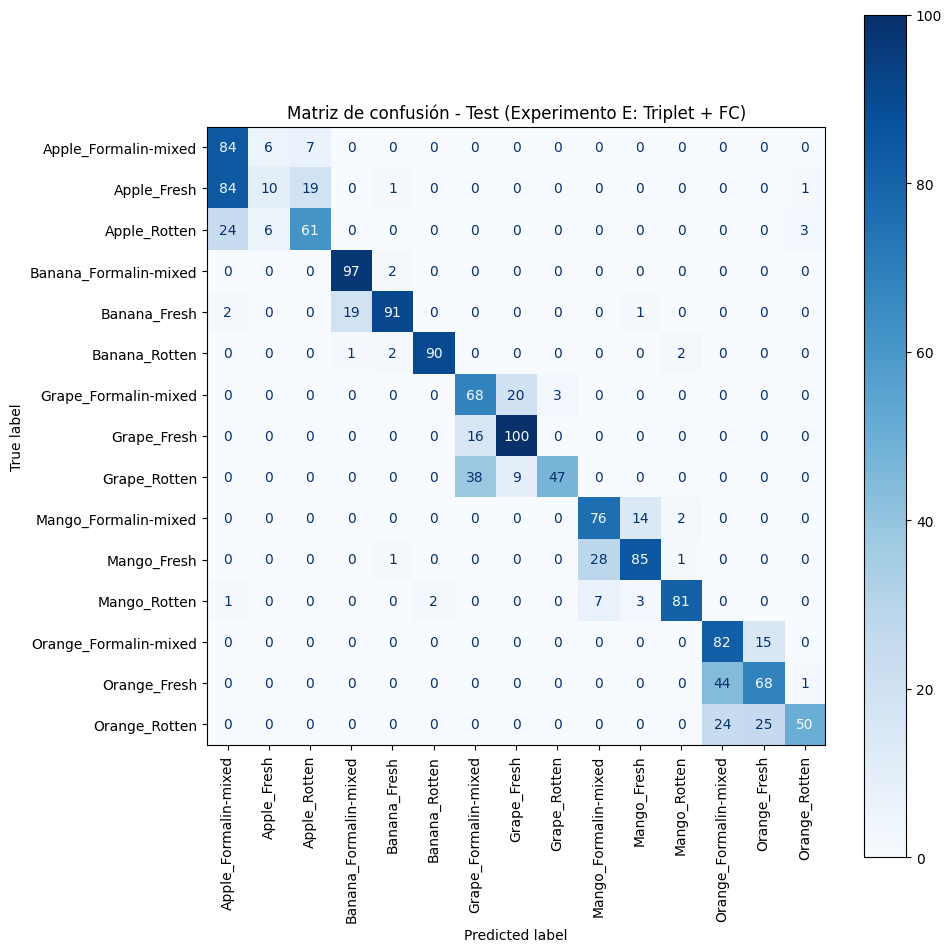

In [ ]:
# ============================================================
# Bloque E10: Entrenar clasificador FC (CrossEntropy)
#             guardando mejor modelo por F1-macro
# ============================================================

CLASSIF_EPOCHS = 12
LR_CLASSIF = 1e-3

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(model_E.classifier.parameters(), lr=LR_CLASSIF)

best_val_f1_E = 0.0
best_state_E = None
history_E = []

def eval_f1_macro(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    return f1_score(all_labels, all_preds, average="macro")

for epoch in range(1, CLASSIF_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model_E, train_loader, optimizer_cls, criterion_cls, DEVICE
    )
    val_loss, val_acc = evaluate(
        model_E, val_loader, criterion_cls, DEVICE
    )
    val_f1 = eval_f1_macro(model_E, val_loader, DEVICE)

    history_E.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc":  train_acc,
        "val_loss":   val_loss,
        "val_acc":    val_acc,
        "val_f1":     val_f1,
    })

    print(f"[Clasif E] Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
          f"Val F1-macro: {val_f1:.4f}")

    if val_f1 > best_val_f1_E:
        best_val_f1_E = val_f1
        best_state_E = model_E.state_dict()

print("\n[Clasif E] Mejor F1-macro en validación:", best_val_f1_E)

if best_state_E is not None:
    model_E.load_state_dict(best_state_E)


In [ ]:
# ======================================================
# Bloque E11: Test final Experimento E (Triplet + FC)
# ======================================================

model_E.eval()
all_preds_E = []
all_labels_E = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model_E(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds_E.extend(preds)
        all_labels_E.extend(yb.numpy())

all_preds_E = np.array(all_preds_E)
all_labels_E = np.array(all_labels_E)

print("=== Experimento E: Reporte de clasificación (TEST) ===\n")
print(classification_report(
    all_labels_E,
    all_preds_E,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))
